Extract Icesat2 data (This code is validate only after downloading HDF5 file)

In [7]:
from pathlib import Path

# Our data folder 
data_home = Path('/home/jovyan/shared/data-Jun/Data')

# Create folder if it doesn't exist
data_home.mkdir(exist_ok=True)

In [8]:
from icepyx import icesat2data as ipd

short_name = 'ATL06'
spatial_extent = [-138.3990209216774,58.85936873949439,-137.44559547328527, 59.306828871347534]  # MLO MODIFIED
date_range = ['2018-10-14','2020-06-16']

region = ipd.Icesat2Data(short_name, spatial_extent, date_range)

In [4]:
%matplotlib widget
print('product:    ', region.dataset)
print('dates:      ', region.dates)
print('start time: ', region.start_time)
print('end time:   ', region.end_time)
print('version:    ', region.dataset_version)
print('extent:     ', region.spatial_extent)

print('\nDATA:')
print('\n'.join([str(item) for item in region.avail_granules().items()]))

region.visualize_spatial_extent()

product:     ATL06
dates:       ['2018-10-14', '2020-06-16']
start time:  00:00:00
end time:    23:59:59
version:     003
extent:      ['bounding box', [-138.3990209216774, 58.85936873949439, -137.44559547328527, 59.306828871347534]]

DATA:
('Number of available granules', 70)
('Average size of granules (MB)', 4.264068085807144)
('Total size of all granules (MB)', 298.48476600649997)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

You can dowload the data by using the below code. I don't recommend it. It would be better to skip next code.

In [ ]:
name = 'mycloso'   # MLO MODIFIED
email = 'michael_loso@nps.gov'   # MLO MODIFIED

# Only download if data folder is empty
if not list(data_home.glob('*.h5')):
    region.earthdata_login(name, email)
    region.download_granules(data_home)

Earthdata Login password:  ···············


['Invalid username or password, please retry.']


Please re-enter your Earthdata user ID:  michael_loso@nps.gov
Earthdata Login password:  ···············


['Invalid username or password, please retry.']


Please re-enter your Earthdata user ID:  michael_loso@nps.gov
Earthdata Login password:  ···············


['Invalid username or password, please retry.']


Please re-enter your Earthdata user ID:  michael_loso@nps.gov
Earthdata Login password:  ···············


['Invalid username or password, please retry.']


Please re-enter your Earthdata user ID:  mycloso
Earthdata Login password:  ···············


Run it from here again

In [9]:
files = list(data_home.glob('*.h5'))

for f in files[:10]: print(f)
print('Total number of files:', len(files))

/home/jovyan/shared/data-Jun/Data/ATL06_20191029184431_05020505_003_01.h5
/home/jovyan/shared/data-Jun/Data/ATL06_20191204043607_10430502_003_01.h5
/home/jovyan/shared/data-Jun/Data/ATL06_20191021190111_03800505_003_01.h5
/home/jovyan/shared/data-Jun/Data/ATL06_20191122050939_08600503_003_01.h5
/home/jovyan/shared/data-Jun/Data/ATL06_20191126050119_09210503_003_01.h5
/home/jovyan/shared/data-Jun/Data/ATL06_20191225033720_13630503_003_01.h5
/home/jovyan/shared/data-Jun/Data/ATL06_20191126045248_09210502_003_01.h5
/home/jovyan/shared/data-Jun/Data/ATL06_20191221034540_13020503_003_01.h5
/home/jovyan/shared/data-Jun/Data/ATL06_20191118050929_07990502_003_01.h5
/home/jovyan/shared/data-Jun/Data/ATL06_20191130044427_09820502_003_01.h5
Total number of files: 24


In [10]:
!h5ls -r {files[0]} 

/                        Group
/METADATA                Group
/METADATA/AcquisitionInformation Group
/METADATA/AcquisitionInformation/lidar Group
/METADATA/AcquisitionInformation/lidarDocument Group
/METADATA/AcquisitionInformation/platform Group
/METADATA/AcquisitionInformation/platformDocument Group
/METADATA/DataQuality    Group
/METADATA/DataQuality/CompletenessOmission Group
/METADATA/DataQuality/DomainConsistency Group
/METADATA/DatasetIdentification Group
/METADATA/Extent         Group
/METADATA/Lineage        Group
/METADATA/Lineage/ANC06-01 Group
/METADATA/Lineage/ANC06-02 Group
/METADATA/Lineage/ANC06-03 Group
/METADATA/Lineage/ANC17  Group
/METADATA/Lineage/ANC19  Group
/METADATA/Lineage/ANC25-06 Group
/METADATA/Lineage/ANC26-06 Group
/METADATA/Lineage/ANC28  Group
/METADATA/Lineage/ANC36-06 Group
/METADATA/Lineage/ANC38-06 Group
/METADATA/Lineage/ATL03  Group
/METADATA/Lineage/ATL09  Group
/METADATA/Lineage/Control Group
/METADATA/ProcessStep    Group
/METADATA/ProcessStep/

In [11]:
import pyproj
from astropy.time import Time

def gps2dyr(time):
    """Converte GPS time to decimal years."""
    return Time(time, format='gps').decimalyear


def orbit_type(time, lat, tmax=1):
    """Separate tracks into ascending and descending.
    
    Defines tracks as segments with time breaks > tmax,
    and tests whether lat increases or decreases w/time.
    """
    tracks = np.zeros(lat.shape)  # generate track segment
    tracks[0:np.argmax(np.abs(lat))] = 1  # set values for segment
    is_asc = np.zeros(tracks.shape, dtype=bool)  # output index array

    # Loop trough individual secments
    for track in np.unique(tracks):
    
        i_track, = np.where(track == tracks)  # get all pts from seg
    
        if len(i_track) < 2: continue
    
        # Test if lat increases (asc) or decreases (des) w/time
        i_min = time[i_track].argmin()
        i_max = time[i_track].argmax()
        lat_diff = lat[i_track][i_max] - lat[i_track][i_min]
    
        # Determine track type
        if lat_diff > 0:  is_asc[i_track] = True
    
    return is_asc


def transform_coord(proj1, proj2, x, y):
    """Transform coordinates from proj1 to proj2 (EPSG num).

    Example EPSG projections:
        Geodetic (lon/lat): 4326
        Polar Stereo AnIS (x/y): 3031
        Polar Stereo GrIS (x/y): 3413
    """
    # Set full EPSG projection strings
    proj1 = pyproj.Proj("+init=EPSG:"+str(proj1))
    proj2 = pyproj.Proj("+init=EPSG:"+str(proj2))
    return pyproj.transform(proj1, proj2, x, y)  # convert


In [26]:
import h5py
import numpy as np

def read_atl06(fname, outdir='data', bbox=None):
    """Read one ATL06 file and output 6 reduced files. 
    
    Extract variables of interest and separate the ATL06 file 
    into each beam (ground track) and ascending/descending orbits.
    """

    # Each beam is a group
    group = ['/gt1l', '/gt1r', '/gt2l', '/gt2r', '/gt3l', '/gt3r']

    # Loop trough beams
    for k, g in enumerate(group):
    
        #-----------------------------------#
        # 1) Read in data for a single beam #
        #-----------------------------------#
        
        data = {}
    
        try:
            # Load vars into memory (include as many as you want)
            with h5py.File(fname, 'r') as fi:
                
                data['lat'] = fi[g+'/land_ice_segments/latitude'][:]
                data['lon'] = fi[g+'/land_ice_segments/longitude'][:]
                data['h_li'] = fi[g+'/land_ice_segments/h_li'][:]
                data['s_li'] = fi[g+'/land_ice_segments/h_li_sigma'][:]
                data['t_dt'] = fi[g+'/land_ice_segments/delta_time'][:]
                data['q_flag'] = fi[g+'/land_ice_segments/atl06_quality_summary'][:]
                data['s_fg'] = fi[g+'/land_ice_segments/fit_statistics/signal_selection_source'][:]
                data['snr'] = fi[g+'/land_ice_segments/fit_statistics/snr_significance'][:]
                data['h_rb'] = fi[g+'/land_ice_segments/fit_statistics/h_robust_sprd'][:]
                data['dac'] = fi[g+'/land_ice_segments/geophysical/dac'][:]
                data['f_sn'] = fi[g+'/land_ice_segments/geophysical/bsnow_conf'][:]
                data['dh_fit_dx'] = fi[g+'/land_ice_segments/fit_statistics/dh_fit_dx'][:]
                data['tide_earth'] = fi[g+'/land_ice_segments/geophysical/tide_earth'][:]
                data['tide_load'] = fi[g+'/land_ice_segments/geophysical/tide_load'][:]
                data['tide_ocean'] = fi[g+'/land_ice_segments/geophysical/tide_ocean'][:]
                data['tide_pole'] = fi[g+'/land_ice_segments/geophysical/tide_pole'][:]
                
                rgt = fi['/orbit_info/rgt'][:]                           # single value
                t_ref = fi['/ancillary_data/atlas_sdp_gps_epoch'][:]     # single value
                beam_type = fi[g].attrs["atlas_beam_type"].decode()      # strong/weak (str)
                spot_number = fi[g].attrs["atlas_spot_number"].decode()  # number (str)
                
        except:
            print('skeeping group:', g)
            print('in file:', fname)
            continue
            
        #---------------------------------------------#
        # 2) Filter data according region and quality #
        #---------------------------------------------#
        
        # Select a region of interest
        if bbox:
            lonmin, lonmax, latmin, latmax = bbox
            bbox_mask = (data['lon'] >= lonmin) & (data['lon'] <= lonmax) & \
                        (data['lat'] >= latmin) & (data['lat'] <= latmax)
        else:
            bbox_mask = np.ones_like(data['lat'], dtype=bool)  # get all
            
        # Only keep good data (quality flag + threshold + bbox)
        mask = (data['q_flag'] == 0) & (np.abs(data['h_li']) < 10e3) & (bbox_mask == 1)
        
        # If no data left, skeep
        if not any(mask): continue
        
        # Update data variables
        for k, v in data.items(): data[k] = v[mask]
            
        #----------------------------------------------------#
        # 3) Convert time, separate tracks, reproject coords #
        #----------------------------------------------------#
        
        # Time in GPS seconds (secs sinde Jan 5, 1980)
        t_gps = t_ref + data['t_dt']

        # Time in decimal years
        t_year = gps2dyr(t_gps)

        # Determine orbit type
        is_asc = orbit_type(t_year, data['lat'])
        
        # Geodetic lon/lat -> Polar Stereo x/y
        x, y = transform_coord(4326, 32607, data['lon'], data['lat'])
      
        data['x'] = x
        data['y'] = y
        data['t_gps'] = t_gps
        data['t_year'] = t_year
        data['is_asc'] = is_asc
        
        #-----------------------#
        # 4) Save selected data #
        #-----------------------#
        
        # Define output dir and file
        outdir = Path(outdir)    
        fname = Path(fname)
        outdir.mkdir(exist_ok=True)
        outfile = outdir / fname.name.replace('.h5', '_' + g[1:] + '.h5')
        
        # Save variables
        with h5py.File(outfile, 'w') as fo:
            for k, v in data.items(): fo[k] = v
            print('out ->', outfile)

In [27]:
!python system-status.py

python: can't open file 'system-status.py': [Errno 2] No such file or directory


In [28]:
outdir = Path.home()/'shared/data-Jun/Data1/'

njobs = 8

bbox = None  #[-1124782, 81623, -919821, -96334]  # Kamb bounding box

outdir.mkdir(exist_ok=True)


if njobs == 1:
    print('running in serial ...')
    [read_atl06(f, outdir, bbox) for f in files]

else:
    print('running in parallel (%d jobs) ...' % njobs)
    from joblib import Parallel, delayed
    Parallel(n_jobs=njobs, verbose=5)(delayed(read_atl06)(f, outdir, bbox) for f in files)


running in parallel (8 jobs) ...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    4.8s
[Parallel(n_jobs=8)]: Done  14 out of  24 | elapsed:    8.4s remaining:    6.0s
[Parallel(n_jobs=8)]: Done  19 out of  24 | elapsed:   10.7s remaining:    2.8s
[Parallel(n_jobs=8)]: Done  24 out of  24 | elapsed:   12.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  24 out of  24 | elapsed:   12.3s finished


In [29]:
#outfiles = !ls {outdir}/*.h5
outfiles = list(outdir.glob('*.h5'))

for f in outfiles[:10]: print(f)
print('Total number of files:', len(outfiles))

/home/jovyan/shared/data-Jun/Data1/ATL06_20191221034540_13020503_003_01_gt2r.h5
/home/jovyan/shared/data-Jun/Data1/ATL06_20191221033709_13020502_003_01_gt3l.h5
/home/jovyan/shared/data-Jun/Data1/ATL06_20191126045248_09210502_003_01_gt2r.h5
/home/jovyan/shared/data-Jun/Data1/ATL06_20191204043607_10430502_003_01_gt2l.h5
/home/jovyan/shared/data-Jun/Data1/ATL06_20191127172032_09440505_003_01_gt1r.h5
/home/jovyan/shared/data-Jun/Data1/ATL06_20191130044427_09820502_003_01_gt2r.h5
/home/jovyan/shared/data-Jun/Data1/ATL06_20191118050929_07990502_003_01_gt2r.h5
/home/jovyan/shared/data-Jun/Data1/ATL06_20191004200533_01210506_003_01_gt3l.h5
/home/jovyan/shared/data-Jun/Data1/ATL06_20181022000240_03570103_003_01_gt1r.h5
/home/jovyan/shared/data-Jun/Data1/ATL06_20191017190928_03190505_003_01_gt1r.h5
Total number of files: 144


In [30]:
!h5ls -r {outfiles[0]}

/                        Group
/dac                     Dataset {32015}
/dh_fit_dx               Dataset {32015}
/f_sn                    Dataset {32015}
/h_li                    Dataset {32015}
/h_rb                    Dataset {32015}
/is_asc                  Dataset {32015}
/lat                     Dataset {32015}
/lon                     Dataset {32015}
/q_flag                  Dataset {32015}
/s_fg                    Dataset {32015}
/s_li                    Dataset {32015}
/snr                     Dataset {32015}
/t_dt                    Dataset {32015}
/t_gps                   Dataset {32015}
/t_year                  Dataset {32015}
/tide_earth              Dataset {32015}
/tide_load               Dataset {32015}
/tide_ocean              Dataset {32015}
/tide_pole               Dataset {32015}
/x                       Dataset {32015}
/y                       Dataset {32015}


Select the data from a wide vriety of parameters.

In [31]:
import h5py
import numpy as np
import dask.dataframe as dd

import warnings
warnings.filterwarnings("ignore")


def read_h5(fname, vnames=[]):
    """Read a list of vars [v1, v2, ..] -> 2D."""
    with h5py.File(fname, 'r') as f:
        return np.column_stack([f[v][()] for v in vnames])

    
# Get list of files to plot
#files = list(Path('/home/jovyan/tutorial-data/gridding-time-series/org').glob('*.h5'))
files = list(outdir.glob('*.h5'))

# Variables we want to plot
#vnames = ['lon', 'lat', 'h_elv']
vnames = ['x', 'y', 'h_li','t_year']

# List with one dataframe per file
dfs = [dd.from_array(read_h5(f, vnames), columns=vnames) for f in files]

# Single parallel dataframe (larger than memory)
df = dd.concat(dfs)

print('Number of files:', len(files))
print('Number of points:', len(df))
print(df.head())

Number of files: 144
Number of points: 1912111
               x             y         h_li       t_year
0  767473.378066  6.607381e+06  1404.785400  2019.970294
1  767470.084337  6.607400e+06  1406.027954  2019.970294
2  763520.559803  6.629979e+06  1423.722168  2019.970294
3  763517.047962  6.629999e+06  1422.662598  2019.970294
4  762401.740253  6.636434e+06  1717.192383  2019.970294


Save it as csv

In [32]:
df.to_csv(str(outdir)+'/points-*.csv')  # -> N csv files

['/home/jovyan/shared/data-Jun/Data1/points-000.csv',
 '/home/jovyan/shared/data-Jun/Data1/points-001.csv',
 '/home/jovyan/shared/data-Jun/Data1/points-002.csv',
 '/home/jovyan/shared/data-Jun/Data1/points-003.csv',
 '/home/jovyan/shared/data-Jun/Data1/points-004.csv',
 '/home/jovyan/shared/data-Jun/Data1/points-005.csv',
 '/home/jovyan/shared/data-Jun/Data1/points-006.csv',
 '/home/jovyan/shared/data-Jun/Data1/points-007.csv',
 '/home/jovyan/shared/data-Jun/Data1/points-008.csv',
 '/home/jovyan/shared/data-Jun/Data1/points-009.csv',
 '/home/jovyan/shared/data-Jun/Data1/points-010.csv',
 '/home/jovyan/shared/data-Jun/Data1/points-011.csv',
 '/home/jovyan/shared/data-Jun/Data1/points-012.csv',
 '/home/jovyan/shared/data-Jun/Data1/points-013.csv',
 '/home/jovyan/shared/data-Jun/Data1/points-014.csv',
 '/home/jovyan/shared/data-Jun/Data1/points-015.csv',
 '/home/jovyan/shared/data-Jun/Data1/points-016.csv',
 '/home/jovyan/shared/data-Jun/Data1/points-017.csv',
 '/home/jovyan/shared/data-J

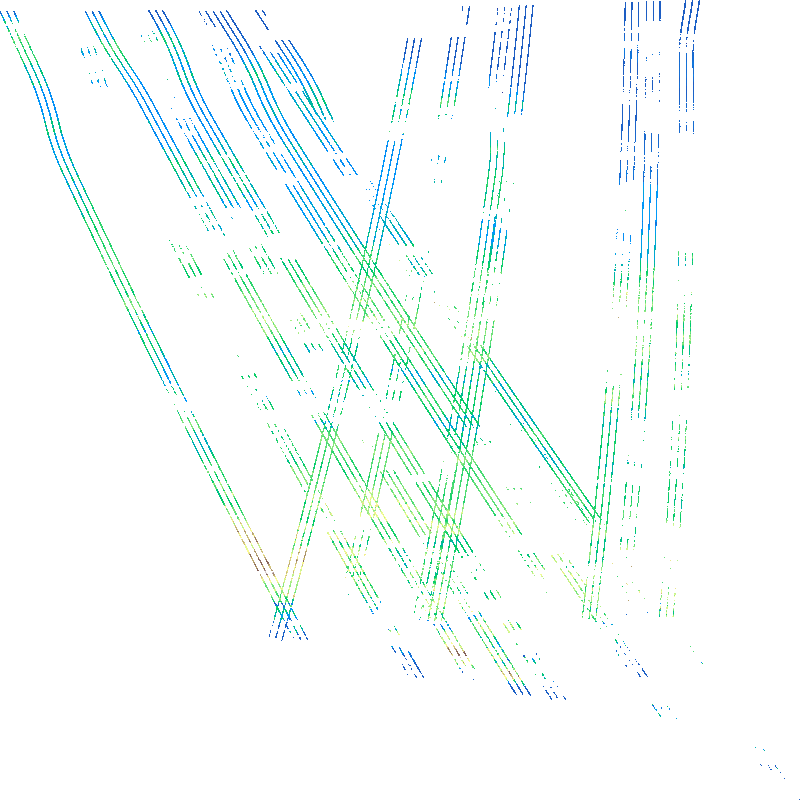

In [33]:
%matplotlib widget
import datashader as ds
import datashader.transfer_functions as tf
from matplotlib.cm import terrain as cmap

df = dd.read_csv(str(outdir)+'/*.csv')

pts = ds.Canvas(plot_width=800, plot_height=800)
#agg = pts.points(df, 'lon', 'lat', ds.mean('h_elv'))
agg = pts.points(df, 'x', 'y', ds.mean('h_li'))
img = tf.shade(agg, cmap=cmap, how='linear')
img

Make grid data from AarcticDEM. It is needed to extract value by Icesat2 data

In [34]:
# print out metadata information
import rasterio as rio
from affine import Affine
from pyproj import Proj, transform as transform
file_in ='/home/jovyan/shared/data-Jun/dem100m.tif'
src = rio.open(file_in)
for k in src.meta:
  print(k,src.meta[k])

# Retrieve the affine transformation
if isinstance(src.transform, Affine):
     transform = src.transform
else:
     transform = src.affine

N = src.width
M = src.height
dx = transform.a
dy = transform.e
minx = transform.c
maxy = transform.f

# Read the image data, flip upside down if necessary
data_in = src.read(1)
if dy < 0:
  dy = -dy
  data_in = np.flip(data_in, 0)

print('Data minimum, maximum( = ', np.amin(data_in), np.amax(data_in))


driver GTiff
dtype float32
nodata -9999.0
width 546
height 546
count 1
crs EPSG:32607
transform | 95.79, 0.00, 650017.17|
| 0.00,-95.79, 6579617.67|
| 0.00, 0.00, 1.00|
Data minimum, maximum( =  nan nan


In [36]:
# Generate X and Y grid locations
xdata = minx + dx/2 + dx*np.arange(N)
ydata = maxy - dy/2 - dy*np.arange(M-1,-1,-1)

Multiple csv files merge into a csv file 

In [37]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import glob
appended_data = []
for infile in glob.glob('/home/jovyan/shared/data-Jun/Data1/*.csv', recursive=True):
    data = pd.read_csv(infile)
    # store DataFrame in list
    appended_data.append(data)
# see pd.concat documentation for more info
appended_data = pd.concat(appended_data)
# write DataFrame to an excel sheet 
appended_data.to_csv('/home/jovyan/shared/data-Jun/Data1/appended.csv')

In [38]:
glas_fn = '/home/jovyan/shared/data-Jun/Data1/appended.csv'
glas_df = pd.read_csv(glas_fn)

glas_gdf = gpd.GeoDataFrame(glas_df, geometry=gpd.points_from_xy(glas_df['x'],\
                                                   glas_df['y']), crs='EPSG:32607')

Check where icesat2 trak go onto ArcticDEM

In [12]:
import rasterio as rio
from rasterio import plot
from affine import Affine
import matplotlib.pyplot as plt
file_in3 ='/home/jovyan/shared/data-Jun/LC08_L1TP_060019_20180703_20180717_01_T1_B8.TIF'
src = rio.open(file_in3)
srtm_extent = rio.plot.plotting_extent(src)
srtm = src.read(1, masked=True)

fig, ax = plt.subplots()
ax.imshow(srtm, extent=srtm_extent)
x1=glas_df['x']
y1=glas_df['y']
ax.scatter(x1,y1,marker='s',s=1,facecolors='none',edgecolors='k')
cs=ax.imshow(srtm, extent=srtm_extent,cmap=plt.get_cmap('Spectral'), interpolation='nearest',
               vmin=-200, vmax=4700)
cs=ax.imshow(srtm, extent=srtm_extent)
cs=fig.colorbar(cs,ax=ax,shrink=0.9)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

NameError: name 'glas_df' is not defined

Compare Icesat2 data with ArcticDEM

In [40]:
ex_ele=[]
for i in range(len(x1)):
    idy = (np.abs(ydata-y1[i])).argmin()
    idx=(np.abs(xdata-x1[i])).argmin()
    ele=data_in[idy,idx]
    ex_ele.append(ele)
z=glas_df['h_li']   
dif=z-ex_ele
df2 = pd.DataFrame({'Z': z[:],'Z1' : ex_ele[:],'Z_Z1':dif[:]})
df_concat = pd.concat([df2,glas_df], axis=1, sort=False)
print(df_concat)

                  Z      Z1          Z_Z1  Unnamed: 0  Unnamed: 0.1  \
0        463.316101 -9999.0  10462.316101           0             0   
1        461.939575 -9999.0  10460.939575           1             1   
2        308.686035 -9999.0  10307.686035           2             2   
3        230.033829 -9999.0  10229.033829           3             3   
4        228.711166 -9999.0  10227.711166           4             4   
...             ...     ...           ...         ...           ...   
1912106  674.867371 -9999.0  10673.867371        8239          8239   
1912107  675.978394 -9999.0  10674.978394        8240          8240   
1912108  568.879456 -9999.0  10567.879456        8241          8241   
1912109  567.561646 -9999.0  10566.561646        8242          8242   
1912110  559.518738 -9999.0  10558.518738        8243          8243   

                     x             y        h_li       t_year  \
0        803548.121030  6.420887e+06  463.316101  2019.970293   
1        803541.1

Finally, Plot on the map 

In [44]:
#import matplotlib.pyplot as plt
#fig, ax = plt.subplots()
#fig = plt.figure()
ax = df_concat.plot(x='x', y='y', kind='scatter', c='Z_Z1', s=1, cmap='RdBu', vmin=-50, vmax=50,zorder=5)
#ax.set_title('Elevation change',size=20)
#ax.set_label('Elevation change (m)',size=15)


#file_in2 ='/home/jovyan/crossovers/Jun/LC08_L1TP_060019_20180703_20180717_01_T1_B8.TIF'
file_in2 ='/home/jovyan/shared/data-Jun/LC08_L1TP_060019_20180703_20180717_01_T1_B8.TIF'
src1 = rio.open(file_in2)
srtm_extent1 = rio.plot.plotting_extent(src1)
srtm1 = src.read(1, masked=True)
ax.imshow(srtm1, extent=srtm_extent1)



Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [45]:
f, ax = plt.subplots()
df_concat['Z_Z1'][df_concat['Z_Z1']>=50]=np.nan
df_concat['Z_Z1'][df_concat['Z_Z1']<=-50]=np.nan
df_concat.hist('Z_Z1', ax=ax, bins=100, range=(-50,50));
ax.axvline(0, color='k')
ax.axvline(df_concat['Z_Z1'].median(), color='r');
print(df_concat['Z_Z1'].median())

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

4.957275390625


In [46]:
ax = df_concat.plot('Z', 'Z_Z1', kind='scatter', s=1)
#Add a horizontal line at 0
ax.axhline(0, color='k', lw=0.5);

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

It would be helpful if we clip data with Polygon data in order to distingish between Ice and Ice free area.